Grafo storico costruito: 2058294 nodi e 4814691 archi


/var/folders/2v/ymm4chds5db2_mn0r_8sr7pm0000gn/T/ipykernel_90240/1570964914.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12241.291666666666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  guest_features.loc[idx, 'similar_guests_avg_commenters'] = np.mean(commenters_counts)
/var/folders/2v/ymm4chds5db2_mn0r_8sr7pm0000gn/T/ipykernel_90240/1570964914.py:95: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.005947302773058387' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  guest_features.loc[idx, 'similar_guests_avg_centrality'] = np.mean(centrality_values)
/var/folders/2v/ymm4chds5db2_mn0r_8sr7pm0000gn/T/ipykernel_90240/1570964914.py:96: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a futur


Training Random Forest...
Random Forest Results:
  Training MSE: 0.0047
  Test MSE: 0.0538
  Training R²: 0.9286
  Test R²: 0.0801

Modello migliore: Random Forest, Test R² = 0.0801

Fine-tuning
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Cross-validation:
R² medio: 0.4257

Final Model Evaluation:
  Test MSE: 0.0505
  Test R²: 0.1378
  Test RMSE: 0.2247


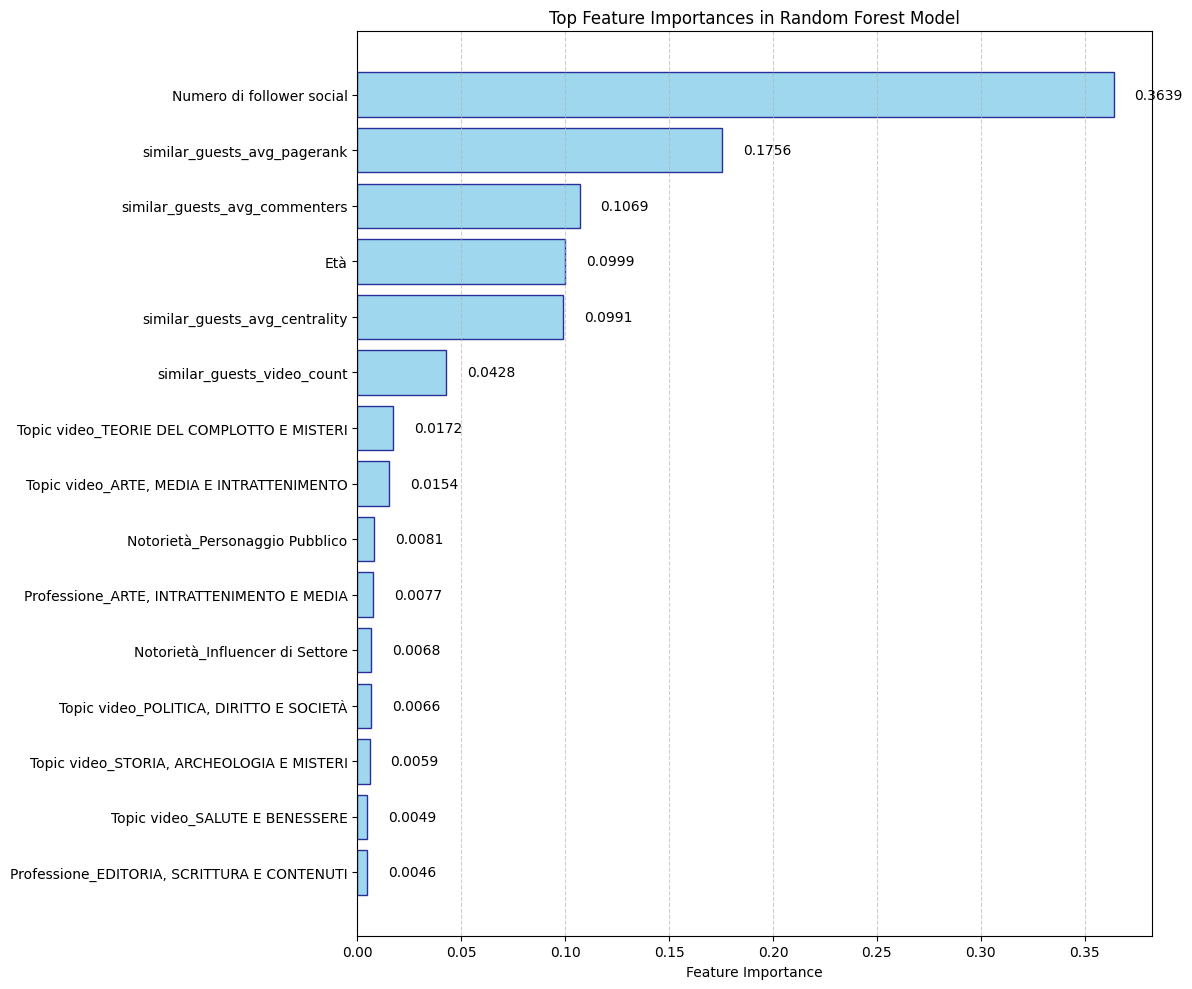

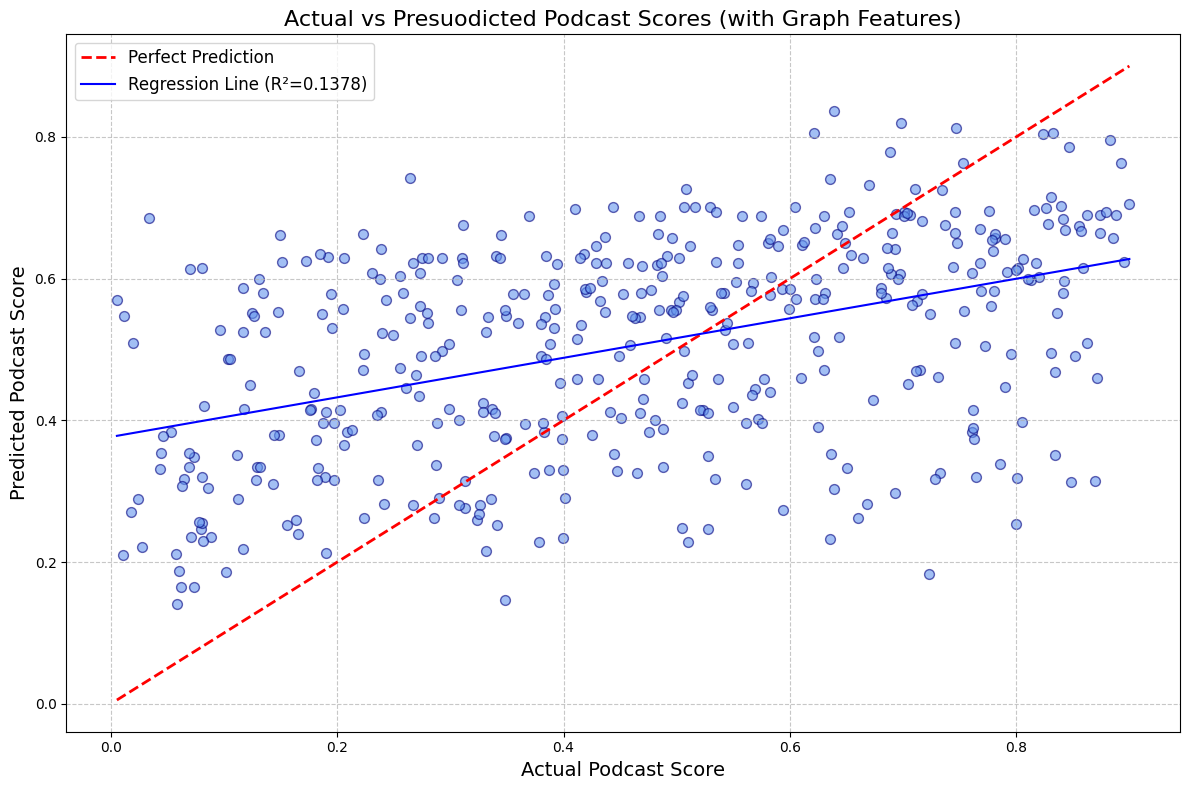

In [3]:
import pandas as pd
import numpy as np
import json
import networkx as nx
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV


def load_data():
    podcast_data = pd.read_csv('../data/guest_data_with_podcast_score.csv')
    with open('../data/video_commenters_final.json', 'r') as f:
        video_commenters = json.load(f)
    return podcast_data, video_commenters

def build_historical_graph(podcast_data, video_commenters, test_indices):
    test_video_ids = set(podcast_data.iloc[test_indices]['video_id'].values)
    
    G = nx.Graph()
    
    for video_id in podcast_data['video_id'].unique():
        if video_id not in test_video_ids:
            G.add_node(video_id, type='video')
    
    for video_id, commenters in video_commenters.items():
        if video_id not in test_video_ids and video_id in podcast_data['video_id'].values:
            for commenter in commenters:
                if commenter not in G:
                    G.add_node(commenter, type='commenter')
                G.add_edge(video_id, commenter)
    
    return G

def extract_guest_features_multilevel(podcast_data, video_commenters, G):
    feature_levels = [
        ['Nazionalità', 'Sesso', 'Professione', 'Notorietà'],  # Molto specifico
        ['Professione', 'Notorietà'],                          # Medio
        ['Professione']                                         # Generale
    ]
    
    degree_centrality = nx.degree_centrality(G) if len(G) > 0 else {}
    pagerank = nx.pagerank(G) if len(G) > 0 else {}
    
    guest_features = pd.DataFrame(index=podcast_data.index)
    guest_features['similar_guests_avg_commenters'] = 0
    guest_features['similar_guests_avg_centrality'] = 0
    guest_features['similar_guests_avg_pagerank'] = 0
    guest_features['similar_guests_video_count'] = 0
    guest_features['match_level'] = 0  # Quale livello di raggruppamento è stato usato
    
    for idx, row in podcast_data.iterrows():
        current_video_id = row['video_id']
        match_found = False
        
        for level_idx, key_features in enumerate(feature_levels):
            if match_found:
                break
                
            char_key = tuple(str(row.get(feature, "unknown")) if pd.notna(row.get(feature, "unknown")) 
                           else "unknown" for feature in key_features)
            
            similar_videos = []
            for i, other_row in podcast_data.iterrows():
                if i != idx and other_row['video_id'] in G:
                    other_key = tuple(str(other_row.get(feature, "unknown")) if pd.notna(other_row.get(feature, "unknown")) 
                                    else "unknown" for feature in key_features)
                    if char_key == other_key:
                        similar_videos.append(other_row['video_id'])
            
            if len(similar_videos) >= 3:
                match_found = True
                guest_features.loc[idx, 'match_level'] = level_idx + 1
                guest_features.loc[idx, 'similar_guests_video_count'] = len(similar_videos)
                
                commenters_counts = []
                centrality_values = []
                pagerank_values = []
                
                for vid in similar_videos:
                    if vid in G:
                        commenters = list(G.neighbors(vid))
                        commenters_counts.append(len(commenters))
                        centrality_values.append(degree_centrality.get(vid, 0))
                        pagerank_values.append(pagerank.get(vid, 0))
                
                if commenters_counts:
                    guest_features.loc[idx, 'similar_guests_avg_commenters'] = np.mean(commenters_counts)
                    guest_features.loc[idx, 'similar_guests_avg_centrality'] = np.mean(centrality_values)
                    guest_features.loc[idx, 'similar_guests_avg_pagerank'] = np.mean(pagerank_values)
        
        if not match_found:
            all_videos = [v for v in G.nodes() if v != current_video_id and v in podcast_data['video_id'].values]
            
            if all_videos:
                guest_features.loc[idx, 'similar_guests_video_count'] = len(all_videos)
                
                commenters_counts = []
                centrality_values = []
                pagerank_values = []
                
                for vid in all_videos:
                    if vid in G:
                        commenters = list(G.neighbors(vid))
                        commenters_counts.append(len(commenters))
                        centrality_values.append(degree_centrality.get(vid, 0))
                        pagerank_values.append(pagerank.get(vid, 0))
                
                if commenters_counts:
                    guest_features.loc[idx, 'similar_guests_avg_commenters'] = np.mean(commenters_counts)
                    guest_features.loc[idx, 'similar_guests_avg_centrality'] = np.mean(centrality_values)
                    guest_features.loc[idx, 'similar_guests_avg_pagerank'] = np.mean(pagerank_values)
    
    return guest_features

podcast_data, video_commenters = load_data()

X_original = podcast_data.drop(['Nome','podcast_score', 'video_id', 'published_at'], axis=1)
y = podcast_data['podcast_score']

categorical_cols = ['Nazionalità', 'Sesso', 'Professione', 'Notorietà', 'Topic video']
numerical_cols = ['Età', 'Numero di follower social']

X_train_indices, X_test_indices, y_train, y_test = train_test_split(
    range(len(X_original)), y, test_size=0.2, random_state=42
)

G = build_historical_graph(podcast_data, video_commenters, X_test_indices)
print(f"Grafo storico costruito: {G.number_of_nodes()} nodi e {G.number_of_edges()} archi")

graph_features = extract_guest_features_multilevel(podcast_data, video_commenters, G)

X = pd.concat([X_original, graph_features], axis=1)
graph_feature_cols = graph_features.columns.tolist()

X_train = X.iloc[X_train_indices]
X_test = X.iloc[X_test_indices]

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

graph_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_cols),
        ('categorical', categorical_transformer, categorical_cols),
        ('graph', graph_transformer, graph_feature_cols)
    ])


models = {
    "Random Forest": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            random_state=42
        ))
    ]),
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    
    results[name] = {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2
    }
    
    print(f"{name} Results:")
    print(f"  Training MSE: {train_mse:.4f}")
    print(f"  Test MSE: {test_mse:.4f}")
    print(f"  Training R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")




best_model_name = max(results, key=lambda k: results[k]['test_r2'])
print(f"\nModello migliore: {best_model_name}, Test R² = {results[best_model_name]['test_r2']:.4f}")


print("\nFine-tuning")

cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [5, 7, 10, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [5, 10]
}

search = RandomizedSearchCV(
    models[best_model_name],
    param_distributions=param_grid,
    n_iter=20,  
    cv=cv_strategy,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

search.fit(X_train, y_train)

best_model = search.best_estimator_

cv_scores = cross_val_score(
    best_model, 
    X_train, 
    y_train, 
    cv=cv_strategy, 
    scoring='r2'
)

print("\nCross-validation:")
print(f"R² medio: {cv_scores.mean():.4f}")

y_pred = best_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print("\nFinal Model Evaluation:")
print(f"  Test MSE: {final_mse:.4f}")
print(f"  Test R²: {final_r2:.4f}")
print(f"  Test RMSE: {np.sqrt(final_mse):.4f}")
    

    
    
# Grafo dell'importanza delle feature
rf_model = best_model.named_steps['regressor']
feature_names = (
    numerical_cols + 
    best_model.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_cols).tolist() +
    graph_feature_cols
)

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 10))
n_features = min(15, len(feature_names))
plt.barh(range(n_features), importances[indices[:n_features]], align='center', color='skyblue', edgecolor='navy', alpha=0.8)
plt.yticks(range(n_features), [feature_names[i] for i in indices[:n_features]])
for i, v in enumerate(importances[indices[:n_features]]):
    plt.text(v + 0.01, i, f"{v:.4f}", va='center')

plt.xlabel('Feature Importance')
plt.title('Top Feature Importances in Random Forest Model')
plt.gca().invert_yaxis()  # Display most important at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Grafico actual vs predicted
plt.figure(figsize=(12, 8)) 
plt.scatter(y_test, y_pred, alpha=0.6, s=50, color='cornflowerblue', edgecolor='navy')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label='Perfect Prediction')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Actual Podcast Score', fontsize=14)
plt.ylabel('Predicted Podcast Score', fontsize=14)
plt.title('Actual vs Presuodicted Podcast Scores (with Graph Features)', fontsize=16)

# Linea di regressione del trend reale
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, y_pred)
plt.plot(np.sort(y_test), intercept + slope*np.sort(y_test), 'b-', 
         linewidth=1.5, label=f'Regression Line (R²={final_r2:.4f})')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
